<a href="https://colab.research.google.com/github/MosaabMuhammed/SetAnomalyDetectionWithTransformer/blob/main/SetAnomalyDetectionWithTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Anomaly Detection

I developed an anomaly detection model using the Transformer Encoder architecture, which was trained to identify an anomalous image from a set of images.

The implementation involved several steps, including the following:

- Building the Transformer Encoder from scratch and utilizing the CIFAR100 dataset.
- To extract image features, I utilized a pre-trained ResNet34 model.
- The input to the transformer consisted of a set of images, one of which was an anomaly, while the remaining images were from the same class.

Moreover, I performed an analysis of the attention weights of the trained model on a correctly labeled example.

The analysis helped in understanding the model's decision-making process and the contribution of each image to the overall prediction.

Throughout the development process, I leveraged the PyTorch and PyTorch Lightning packages to streamline the development and training of the model.

Overall, this project demonstrated my expertise in implementing deep learning models and effectively utilizing pre-trained models and attention mechanisms for anomaly detection.

## Transformer:

### Imports:

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

from tqdm.notebook import tqdm

try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet lightning
    import lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [ ]:
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Device: cuda:0


### Scaled Dot Product:

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits /= math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [ ]:
seq_len, d_k = 3, 2
pl.seed_everything(42)

q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)

values, attention = scaled_dot_product(q, k, v)

print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


### Multi-Head Attention:

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initializeation, see pytorch docs
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)

        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        B, T, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(B, T, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [B, Head, T, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [B, T, Head, Dims]
        values = values.reshape(B, T, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

### Encoder Block:

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input.
            num_heads - Number of heads to use in the attention.
            dim_feedforward - Dimensionality of the hidden layer.
            dropout - Dropout probability to use in the dropout.
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP Part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

### Transformer Encoder:

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional Encoding:

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Inputs:
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10_000) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a paramter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module
        # persistent=False tells pytorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

### Learning Rate Warm-up:

In [ ]:
import numpy as np

class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

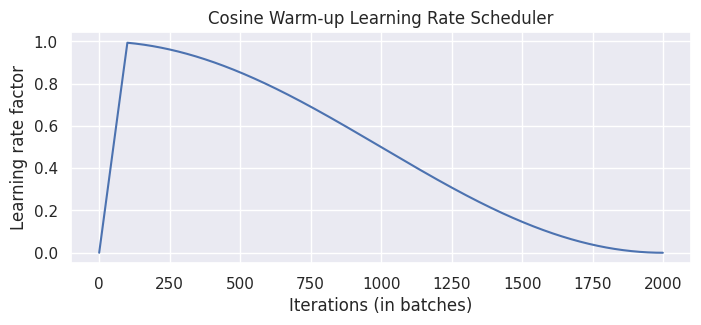

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

p = nn.Parameter(torch.empty(4, 4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

### Lightning Module:

In [ ]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences.
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError
    
    def validation_step(self, batch, batch_idx):
        raise NotImplementedError
    
    def test_step(self, batch, batch_idx):
        raise NotImplementedError

# Anomaly Detection

The task we are looking at for sets is Set Anomaly Detection which means that we try to find the element(s) in a set that does not fit the others. <br>

In the research community, the common application of anomaly detection is performed on a set of images, where 
 images belong to the same category/have the same high-level features while one belongs to another category. 
 
 Note that category does not necessarily have to relate to a class in a standard classification problem, but could be the combination of multiple features. For instance, on a face dataset, this could be people with glasses, male, beard, etc. 
 
 An example of distinguishing different animals can be seen below. The first four images show foxes, while the last represents a different animal. We want to recognize that the last image shows a different animal, but it is not relevant which class of animal it is.

## Imports

In [ ]:
import os
import numpy as np
import random
import math
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [ ]:
DATASET_PATH = "/content/dataset"
CHECKPOINT_PATH = "/content/saved_models"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Download Dataset:
Since we are going to use pretrained ResNet34 model that was trained on images scaled to 224x224, hence we need to rescale our CIFAR100 images to this resolution as well.

In [ ]:
# Imagenet statistics used to normalize the images.
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD   = np.array([0.229, 0.224, 0.225])

# Convert them to PyTorch Tensors
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1, 3, 1, 1)
TORCH_DATA_STD   = torch.from_numpy(DATA_STD).view(1, 3, 1, 1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)])

# Loading the training & testing dataset.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)
test_set  = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

100%|██████████| 169001437/169001437 [00:13<00:00, 12876582.75it/s]


Extracting /content/dataset/cifar-100-python.tar.gz to /content/dataset
Files already downloaded and verified


## Download ResNet34

Next, we need to run the pre-trained ResNet model on the images, and extract the features before the classification layer.

These features are the most high-level features, and should suffcently describe the images.

In [ ]:
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights="IMAGENET1K_V1")

# Remove classification layer
# In some models, it's called "FC", others have "classifier"
# so make sure by printing the pretrained_model architecture
pretrained_model.fc = nn.Sequential()

# To GPU
pretrained_model = pretrained_model.to(DEVICE)

# freeze the parameters of the model
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /content/saved_models/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 357MB/s]


## Features Extraction

The dimension of the extracted features is 512.

In [ ]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []

        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(DEVICE)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features


In [ ]:
train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
print("Train:", train_set_feats.shape)
print("Test:", test_feats.shape)

Train: torch.Size([50000, 512])
Test: torch.Size([10000, 512])


## Split Dataset

Next, we will split the training set into 90% training, 10% validation.

The challenge here is that we need to ensure that the validation set has the same number of images for all 100 labels.

Otherwise, we have a class imbalance which is not good for creating the image sets.

Hence, we take only 10% of the images for each class, and move them into the validation set.

In [ ]:
# Get labels from train set
labels = train_set.targets # dtype: list

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1

# Since we have the same number of images per label
# We can grab the id for each sample and assign it to its proper class/label.
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine the number of validation
num_val_exmps = sorted_indices.shape[1] // 10 # 500 // 10 = 50 validation samples.

# Get images indices for validation and training
val_indices = sorted_indices[:, :num_val_exmps].reshape(-1)
train_indices = sorted_indices[:, num_val_exmps:].reshape(-1)

# Group corresponding image features and labels.
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats, val_labels     = train_set_feats[val_indices],   labels[val_indices]

print(len(train_indices), len(val_indices))

45000 5000


In [ ]:
val_feats.shape, val_labels.shape

(torch.Size([5000, 512]), torch.Size([5000]))

## AnomalyDataset Class

Now, we need to prepare a dataset class for the set anomaly task.

We define an epoch to be the sequence in which each image has been exactly once as an "anomaly".

Hence, the length of the dataset is the number of images in it.

For the training set, each time we access an item with `__getitem__`, we sample a random, different class than the image at the corresponding index `idx` has.

In the second step, we sample `N-1` images of this sampled class.

The set of 10 images is finally returned.

However, we can't use the same strategy for the test set as we want the test dataset to be the same every time we iterate over it.

In [ ]:
class SetAnomalyDataset(Dataset):

    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features from ResNet34
            labels    - Tensor of shape [num_imgs], containing the class labels for the images.
            set_size  - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train     - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels    = labels
        self.set_size  = set_size-1
        self.train     = train

        # Tensor with indices of the images per class.
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)

        if not train:
            self.test_sets = self._create_test_sets()

    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set.
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets

    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly.
        The sampled images come from a different class than anomaly_label.
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1

        # sample images from the class determined above.
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices

    def __len__(self):
        return self.img_feats.shape[0]

    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train:
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones.
            img_indices = self.test_sets[idx]

        # Concatenate images. The anomaly is always the last image for simplicity.
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1 # the label will be always the last because the anomaly image is at the last position.

        return img_set, indices, label
        

Next, we can setup our datasets and data loaders as shown below.

In [ ]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = DataLoader(train_anom_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_anom_loader   = DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader  = DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


To understand the dataset a little better, we can plot below a few sets from the test set.

As you can see the first 9 images from the same class, but the last image is from different class, hence it's the anomaly image.

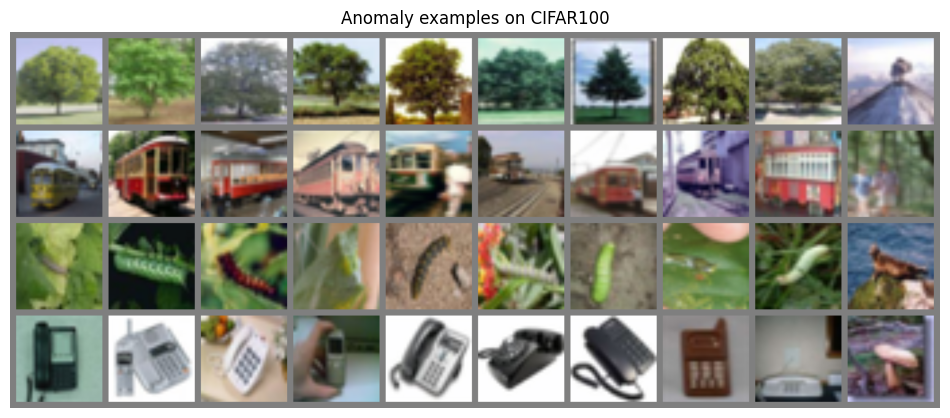

In [ ]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS

    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

## Anomaly Predictor

In [ ]:
class AnomalyPredictor(TransformerPredictor, pl.LightningModule):

    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False) # No need for positional encoding, since it's not a sequence!
        preds = preds.squeeze(dim=-1)
        loss = F.cross_entropy(preds, labels)  # (batch_size, set_size), (batch_size,)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")


Finally, we write our train function below.

In [ ]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback.
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)

    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(DEVICE).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=100,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need.

    # Check whether pretrained model exists. If yes, load it and skip training.
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")

    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs * len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    train_result = trainer.test(model, train_anom_loader, verbose=False)
    val_result   = trainer.test(model, val_anom_loader, verbose=False)
    test_result  = trainer.test(model, test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], 
              "val_acc": val_result[0]["test_acc"],
               "train_acc": train_result[0]["test_acc"]}

    model = model.to(DEVICE)
    return model, result

Now, let's finally train our model. We will use 4 layers with 4 attention heads each.

Note that we also apply the dropout on the input features, as this makes the model more robust agains image noise and generalizes better.

We use warmup to slowly start our model training.

In [ ]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params
-----------------------------------------------------------
0 | input_net           | Sequential         | 131 K 
1 | positional_encoding | PositionalEncoding | 0     
2 | transformer         | TransformerEncoder | 2.1 M 
3 | output_net          | Sequential         | 66.6 K
-----------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.225     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [ ]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 98.65%
Val accuracy:   94.48%
Test accuracy:  95.43%


With ~94/95% validation and test accuracy, the model generalizes quite well.

Now, let's verify that our model is permutation-equivariant, and assigns the same predictions for different permutations of the input set.

For this we sample a batch from the test set and run it through the model to obtain the probabilities.

## Permutation-equivariant

In [ ]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(DEVICE)

anomaly_model.eval()

with torch.inference_mode():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permute input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:, permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:, permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0, permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [2.6344921e-08 2.5915368e-08 2.5529504e-08 2.8216306e-08 2.7538347e-08
 2.9368760e-08 2.6417833e-08 9.9999988e-01 4.0560710e-08 2.6696426e-08]
Permuted preds
 [2.6344868e-08 2.5915366e-08 2.5529454e-08 2.8216302e-08 2.7538290e-08
 2.9368756e-08 2.6417830e-08 9.9999976e-01 4.0560629e-08 2.6696423e-08]


We can see that the probabilities are almost exactly the same, and only differ because of slight numerical differences inside the network operation.

## Attention Interpretation

To interpret the model a little more, we can plot the attention maps inside the model.

This will give us an idea of what information the model is sharing/communicating between images, and what each head might represent.

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

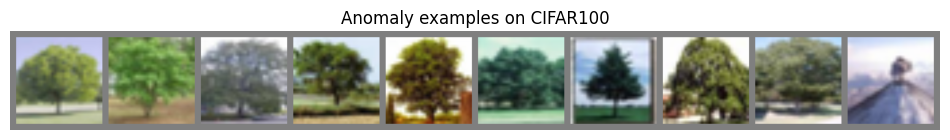

Prediction: 9


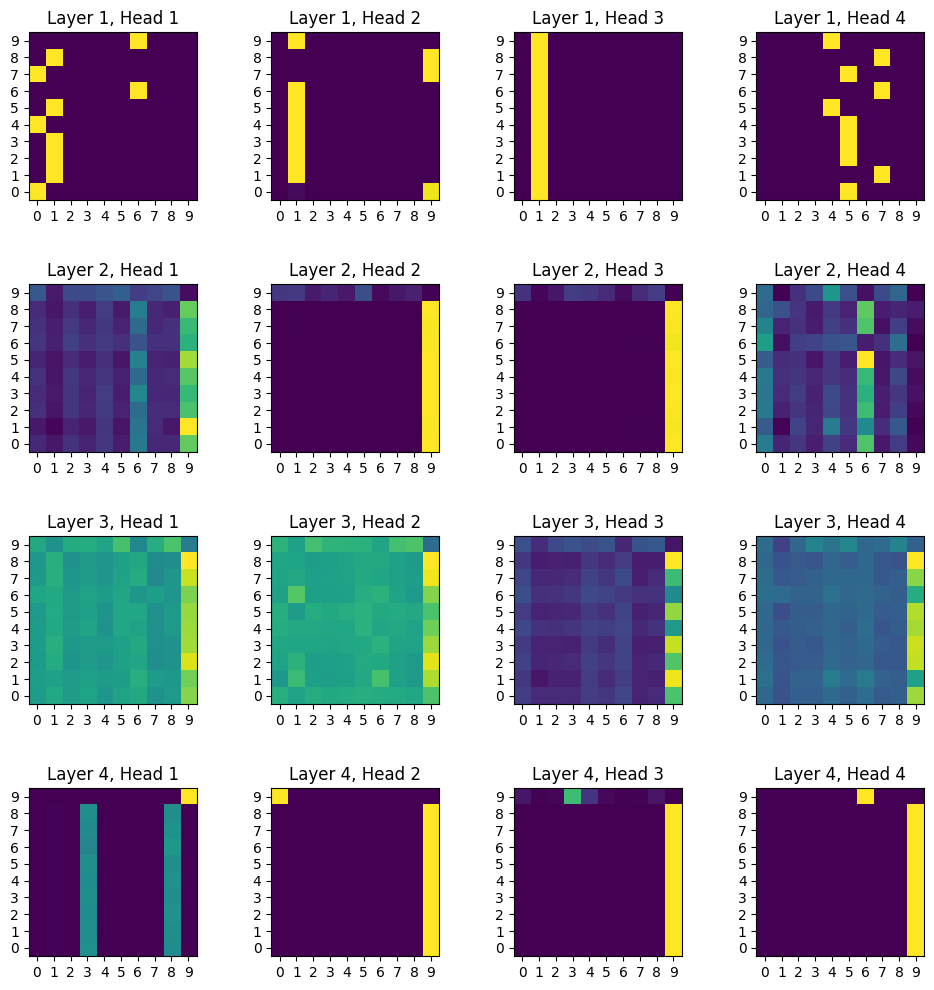

In [ ]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx: idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

We can see that Layer 2 - Head 2, Layer 2 - Head 3, Layer 3 - Head 3, Layer 4 - Head 2, Layer 4 - Head 3, Layer 4 - Head 4 are focusing on the last image.

This shows that the model has indeed recognized that the image doesn't fit the setting, and hence predicted it to be anomaly.

That's it, see you in the next project 😀